---

## Deep Learning Coding Project 3-3: Variational Auto-Encoder

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 小明, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. To avoid unexpected issues with PyTorch 2.0, we recommend using PyTorch version 1.x.

In this coding project, you will implement 2 generative models, i.e., energy-based model, (variational auto-encoder / generative adverserial network), to generate MNIST images.

**We will implement a conditional variational auto-encoder (CVAE) in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Unless otherwise stated, do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to implement a class conditioned variational autoencoder to generate MNIST images. We suppose the prior $p(z)$ is a
standard Gaussian distribution $\mathcal{N} (0, I)$. Also, we assume $q(z|x, y)$ and $p(x|z, y)$
are Gaussian distributions.

1. **You need to complete the encoder $q(z|x, y; \phi)$ and the decoder $p(x|z, y; \theta)$, which are both MLPs**.

2. **Implement the VAE loss function.**

An example of generated images using CVAE is shown below.

If you use Colab in this coding project, please uncomment the cell below, change the `GOOGLE_DRIVE_PATH` to your project folder and run the following cell to mount your Google drive. Then, the notebook can find the required files (i.e., utils.py). If you run the notebook locally, you can skip this cell.

In [1]:
# ### uncomment this cell if you're using Google colab
# from google.colab import drive
# drive.mount('/content/drive')

# ### change GOOGLE_DRIVE_PATH to the path of your CP3 folder
# GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/DL23SP/CP3'
# %cd $GOOGLE_DRIVE_PATH

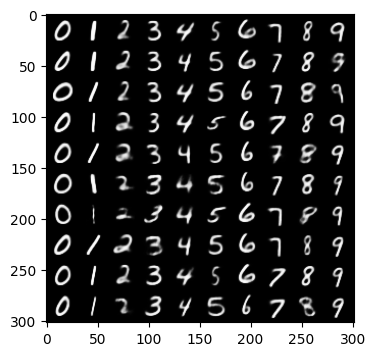

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 6, 4
plt.imshow(mpimg.imread('./vae/sample.png'))

### Submission

You need to submit your code (this notebook), your trained VAE model (named `./vae/vae_best.pth`), your generated images, and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Generator**

In this notebook, we select the best model based on validation loss. You can also manually select the best one, and save it as `./vae/vae_best.pth`. **Please do not submit any other checkpoints except for `./vae/vae_best.pth`!**

+ **Generated Images**

Please generate 100 images for each class (1000 in total), save it in `./vae/generated/`, and organize them as the following structure:

```
CodingProject3
├── ...
├── vae
│   ├── vae_best.pth
│   ├── generated
│       └── 0
│           ├── 0_00.png
│           ├── ...
│           ├── 0_99.png
│       └── 1
│           ├── 1_00.png
│           ├── ...
│           ├── 1_99.png
│       └── ...
│       └── 9
│           ├── 9_00.png
│           ├── ...
│           ├── 9_99.png
```

Specifially, you should name the $j$-th generated image of class $i$ as `{i}_{j}.png`, and save it into folder `./vae/generated/{i}/`. Check the `make_dataset` method of VAE model for details.

+ **Report**

Please include the conditioned generation results (i.e., generated images in a $10\times 10$ array as above), the FID score, the standard deviation for each class, and other relevant statistics in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**. We have provided a fine-tuned Inception-V3 model, which will be used by our evaluation script to compute FID score.

## Set Up Code

If you use Colab in this coding project, please make sure to mount your drive before running the cells below.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from utils import hello
hello()

Good luck!


Please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [5]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, train_set, val_set
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

/tmp/ipykernel_1612406/2392988082.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## VAE Model

Complete the conditional VAE model with structure shown in doc strings.

**Hint**: we usually output logarithm standard deviation.

In [6]:
class CVAE(nn.Module):
    def __init__(self, img_size, label_size, latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.img_size = img_size  # (C, H, W)
        self.label_size = label_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        
        # Encoder.
        '''
        img   -> fc  ->                   -> fc -> mean    
                        concat -> encoder                  -> z
        label -> fc  ->                   -> fc -> logstd 
        '''
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        flatten_img_size = img_size[0] * img_size[1] * img_size[2]
        self.fc_img = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_img_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.SiLU(),
        )
        self.fc_label = nn.Sequential(
            nn.Linear(label_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.SiLU(),
        )
        self.fc_mu = nn.Sequential(
            nn.Linear(4 * hidden_size, 4*hidden_size),
            nn.SiLU(),
            nn.Linear(4*hidden_size, 2* hidden_size),
            nn.SiLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, latent_size)            
        )
        self.f_sigma = nn.Sequential(
            nn.Linear(4 * hidden_size, 4*hidden_size),
            nn.SiLU(),
            nn.Linear(4*hidden_size, 8* hidden_size),
            nn.SiLU(),
            nn.Linear(8*hidden_size, 4*hidden_size),
            nn.SiLU(),
            nn.Linear(4*hidden_size, 2* hidden_size),
            nn.SiLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, latent_size)
        )
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################
        
        # Decoder.
        '''
        latent -> fc ->
                         concat -> decoder -> reconstruction
        label  -> fc ->
        '''
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.latent_fc_decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.SiLU()
        )
        self.fc_label_decoder = nn.Sequential(
            nn.Linear(label_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.SiLU()
        )
        self.xij = nn.Sequential(
            nn.Linear(4 * hidden_size, 4*hidden_size),
            nn.SiLU(),
            nn.Linear(4 * hidden_size, 8*hidden_size),
            nn.SiLU(),
            nn.Linear(8*hidden_size, 4*hidden_size),
            nn.SiLU(),
            nn.Linear(4*hidden_size, 2* hidden_size),
            nn.SiLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, flatten_img_size),
        )
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def encode_param(self, x, y):
        # compute mu and logstd of p(z|x, y)
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        # print(x.shape)
        # print(y.shape)
        # print(self.fc_img(x).shape)
        # print(self.fc_label(y).shape)
        y = F.one_hot(y,num_classes=10).to(torch.float32)
        cat_result = torch.cat([self.fc_img(x), self.fc_label(y)], dim=1)
        mu = self.fc_mu(cat_result)
        sigma = self.f_sigma(cat_result)
        return mu, sigma
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def reparamaterize(self, mu: torch.Tensor, logstd: torch.Tensor):
        # compute latent z with reparameterization trick
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        # raise NotImplementedError()
        z = mu + torch.exp(logstd) * torch.randn_like(logstd)
        return z
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def encode(self, x, y):
        # sample latent z from p(z|x, y)
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        mu, sigma = self.encode_param(x, y)
        z = self.reparamaterize(mu, sigma)
        return z, mu, sigma
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def decode(self, z, y):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        # print(z.shape)
        # print(y.shape)
        if not torch.is_floating_point(y):
            y = F.one_hot(y,num_classes=10).to(torch.float32)
        cat_result = torch.cat([self.latent_fc_decoder(z), self.fc_label_decoder(y)], dim=1)
        xij = self.xij(cat_result)
        ones = torch.ones_like(xij)
        return self.reparamaterize(xij, ones)
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./vae'):
        self.eval()
        n_samples = label.shape[0]
        samples  = self.decode(torch.randn(n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28).clamp(0., 1.)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./vae/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = torch.zeros(n_samples_per_class, self.label_size, device=device)
            label[:, i] = 1
            samples = self.decode(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28).clamp(0., 1.)
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))


## VAE Loss

Given image $x$ and corresponding label $y$, compute the VAE loss in the following function.

**Hint**: $p(x|z, y)$ is a real-valued Gaussian distribution, while images are in range $[0, 1]$. Therefore, you may want to transform $x$ when computing $p(x|z, y)$.

In [7]:
def compute_vae_loss(vae_model:CVAE, x, y, beta=1):
    # compute vae loss for input x and label y
    ##############################################################################
    #                  TODO: You need to complete the code here                  #
    ##############################################################################
    # YOUR CODE HERE
    x = torch.logit(x)
    
    mu,sigma = vae_model.encode_param(x,y)
    eps = torch.randn_like(mu)
    z = mu + eps*torch.exp(sigma)
    f = vae_model.xij(torch.cat((vae_model.latent_fc_decoder(z),vae_model.fc_label_decoder(F.one_hot(y,num_classes=10).to(torch.float32))),dim=1))
    # print(f.shape)
    # print(x.shape)
    reconstruction_loss = -0.5 * (torch.norm(f-x)**2) 
    kl_penalty = 0.5*(torch.sum(torch.exp(2*sigma))+torch.norm(mu)**2-2*torch.sum(sigma))

    return  - reconstruction_loss + beta * kl_penalty # approx to reconstruction_loss
    ##############################################################################
    #                              END OF YOUR CODE                              #
    ##############################################################################

## Training & Evaluation

We have implemented the training and evaluation functions. Feel free to modify `train` if you want to monitoring more information. Make sure your best model is stored in `'./vae/vae_best.pth'`.

In [8]:
@torch.no_grad()
def evaluate(vae_model, loader, device, beta):
    vae_model.eval()
    val_loss = 0
    n_batches = 0

    pbar = tqdm(total=len(loader.dataset))
    pbar.set_description('Eval')
    for batch_idx, (x, y) in enumerate(loader):
        n_batches += x.shape[0]
        x = x.view(x.shape[0], -1).to(device)
        y = y.to(device)

        val_loss += compute_vae_loss(vae_model, x, y, beta).sum().item()
        pbar.update(x.size(0))
        pbar.set_description('Val Loss: {:.6f}'.format(val_loss / n_batches))

    pbar.close()
    return val_loss / n_batches

In [9]:
def train(n_epochs, vae_model, train_loader, val_loader, optimizer, scheduler, beta=1, device=torch.device('cuda'), save_interval=10, now_epoch=0):
    vae_model.to(device)
    best_val_loss = np.inf
    ibar = tqdm(range(n_epochs))
    for epoch in range(n_epochs):
        train_loss = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for i, (x, y) in enumerate(train_loader):
            # compute loss
            vae_model.train()
            n_batches += x.shape[0]
            x = x.view(x.shape[0], -1).to(device)
            y = y.to(device)
            loss = compute_vae_loss(vae_model, x, y, beta)

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            train_loss += loss.sum().item()

            pbar.update(x.size(0))
            pbar.set_description('Train Epoch {}, Train Loss: {:.6f}, Learning Rate {}'.format(epoch + 1, train_loss / n_batches, optimizer.param_groups[0]['lr']))
        pbar.close()
        if scheduler is not None:
            scheduler.step()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./vae/{epoch + 1 + now_epoch}', exist_ok=True)
            vae_model.eval()
            save_model(f'./vae/{epoch + 1 + now_epoch}/vae.pth', vae_model, optimizer)

            val_loss = evaluate(vae_model, val_loader, device, beta=beta)

            # sample and save images
            label = torch.eye(10).repeat(10, 1).to(device)
            vae_model.sample_images(
                label, save=True, save_dir=f"./vae/{epoch + 1 + now_epoch}/")
            
            if val_loss < best_val_loss:
                print(
                    f'Current validation loss: {best_val_loss} -> {val_loss}')
                best_val_loss = val_loss
                save_model('./vae/vae_best.pth', vae_model)
                
        ibar.update(1)
        ibar.set_description(f'Epoch {epoch+1}, Train Loss: {train_loss/n_batches}')
    ibar.close()

## Enjoy

Tune your hyperparameters and make your conditional VAE work. Good luck!

In [11]:
from torchsummary import summary

label_dim = 10
img_dim = (1, 28, 28)
latent_dim = 100
cvae = CVAE(img_dim, 10, 100, 256)
cvae.load_state_dict(load_model('./vae/vae_best.pth')[0])
cvae.to(device)
# Calculate the total number of trainable parameters in the CVAE model
total_params = sum(p.numel() for p in cvae.parameters() if p.requires_grad)
print(f"Total trainable parameters in CVAE: {total_params}")
train_loader = DataLoader(train_set, batch_size=1024, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=1024, pin_memory=True,
                        drop_last=True, shuffle=True, num_workers=8)
optimizer = torch.optim.Adam(cvae.parameters(), lr=2e-4)

/scorpio/home/liuhanzuo/DL2025/CodingProject3/utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


Total trainable parameters in CVAE: 14523608


Let's start training! Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [ ]:
# feel free to change training hyper-parameters!
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-5)
train(500, cvae, train_loader, val_loader, optimizer, scheduler=scheduler,device=device, save_interval=10, now_epoch=500)

Train Epoch 1, Train Loss: 969.342450, Learning Rate 0.0001: 100%|██████████| 60000/60000 [00:02<00:00, 20851.33it/s]
Train Epoch 2, Train Loss: 929.032396, Learning Rate 9.999911173852618e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27868.36it/s]
Train Epoch 3, Train Loss: 929.786680, Learning Rate 9.999644698917175e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27062.49it/s]
Train Epoch 4, Train Loss: 930.475305, Learning Rate 9.999200585713642e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30109.74it/s]
Train Epoch 5, Train Loss: 930.523066, Learning Rate 9.998578851774852e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27338.29it/s]
Train Epoch 6, Train Loss: 930.351025, Learning Rate 9.997779521645794e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26476.31it/s]
Train Epoch 7, Train Loss: 930.243348, Learning Rate 9.996802626882654e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27543.33it/s]
Train Epoch 8, Train Loss: 929.642665, Learning Rate 9.995648206051564e-05: 100%|███

Current validation loss: inf -> 1030.1415473090278


Train Epoch 11, Train Loss: 927.539072, Learning Rate 9.991120277927223e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29113.97it/s]
Train Epoch 12, Train Loss: 927.263008, Learning Rate 9.989256278625514e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30684.23it/s]
Train Epoch 13, Train Loss: 926.987609, Learning Rate 9.987215051172763e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28461.56it/s]
Train Epoch 14, Train Loss: 926.720110, Learning Rate 9.984996676153134e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30531.65it/s]
Train Epoch 15, Train Loss: 924.905935, Learning Rate 9.982601241144277e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27700.80it/s]
Train Epoch 16, Train Loss: 924.706515, Learning Rate 9.980028840713861e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29182.41it/s]
Train Epoch 17, Train Loss: 923.615778, Learning Rate 9.977279576415853e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27385.15it/s]
Train Epoch 18, Train Loss: 923.557477, Learning Rate 9.974353

Current validation loss: 1030.1415473090278 -> 1027.0150078667534


Train Epoch 21, Train Loss: 921.750505, Learning Rate 9.964516155915151e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26414.31it/s]
Train Epoch 22, Train Loss: 920.675483, Learning Rate 9.96088433981278e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28995.24it/s]
Train Epoch 23, Train Loss: 919.736927, Learning Rate 9.95707641563493e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30884.58it/s]
Train Epoch 24, Train Loss: 919.039003, Learning Rate 9.95309253371193e-05: 100%|██████████| 60000/60000 [00:01<00:00, 33078.32it/s]
Train Epoch 25, Train Loss: 919.581533, Learning Rate 9.948932851320614e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27244.39it/s]
Train Epoch 26, Train Loss: 917.799070, Learning Rate 9.94459753267812e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25137.25it/s]
Train Epoch 27, Train Loss: 917.323374, Learning Rate 9.940086748935406e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26124.75it/s]
Train Epoch 28, Train Loss: 916.073993, Learning Rate 9.9354006781

Current validation loss: 1027.0150078667534 -> 1024.1470269097222


Train Epoch 31, Train Loss: 915.068818, Learning Rate 9.920292628279102e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26822.37it/s]
Train Epoch 32, Train Loss: 913.819300, Learning Rate 9.914907328495006e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30360.88it/s]
Train Epoch 33, Train Loss: 912.467870, Learning Rate 9.909347735729114e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26540.85it/s]
Train Epoch 34, Train Loss: 912.262231, Learning Rate 9.903614069464627e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27265.58it/s]
Train Epoch 35, Train Loss: 911.829335, Learning Rate 9.897706556056874e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29469.57it/s]
Train Epoch 36, Train Loss: 911.225589, Learning Rate 9.891625428724367e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30141.14it/s]
Train Epoch 37, Train Loss: 910.350534, Learning Rate 9.885370927539601e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26540.98it/s]
Train Epoch 38, Train Loss: 909.310888, Learning Rate 9.878943

Current validation loss: 1024.1470269097222 -> 1019.0506388346354


Train Epoch 41, Train Loss: 907.723573, Learning Rate 9.858624225078843e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27777.85it/s]
Train Epoch 42, Train Loss: 906.599999, Learning Rate 9.851506694930961e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28263.26it/s]
Train Epoch 43, Train Loss: 905.952867, Learning Rate 9.844217374749735e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25069.63it/s]
Train Epoch 44, Train Loss: 906.002425, Learning Rate 9.836756552305047e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30775.34it/s]
Train Epoch 45, Train Loss: 904.620854, Learning Rate 9.82912452213739e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27918.03it/s]
Train Epoch 46, Train Loss: 903.709259, Learning Rate 9.821321585546247e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27851.05it/s]
Train Epoch 47, Train Loss: 903.700996, Learning Rate 9.813348050578194e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27608.55it/s]
Train Epoch 48, Train Loss: 903.249786, Learning Rate 9.8052042

Current validation loss: 1019.0506388346354 -> 1018.3184814453125


Train Epoch 51, Train Loss: 900.489158, Learning Rate 9.779754323328194e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30403.18it/s]
Train Epoch 52, Train Loss: 899.995944, Learning Rate 9.770932652456327e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27384.37it/s]
Train Epoch 53, Train Loss: 899.155822, Learning Rate 9.761942372476349e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26181.63it/s]
Train Epoch 54, Train Loss: 898.653994, Learning Rate 9.752783838309121e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26310.11it/s]
Train Epoch 55, Train Loss: 898.385255, Learning Rate 9.74345741151789e-05: 100%|██████████| 60000/60000 [00:02<00:00, 23608.28it/s]
Train Epoch 56, Train Loss: 898.343521, Learning Rate 9.733963460294015e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29006.47it/s]
Train Epoch 57, Train Loss: 896.869518, Learning Rate 9.724302359442434e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29189.54it/s]
Train Epoch 58, Train Loss: 896.387086, Learning Rate 9.7144744

Current validation loss: 1018.3184814453125 -> 1011.8129950629341


Train Epoch 61, Train Loss: 894.634630, Learning Rate 9.68399418649713e-05: 100%|██████████| 60000/60000 [00:01<00:00, 33297.61it/s]
Train Epoch 62, Train Loss: 893.370866, Learning Rate 9.673503190005974e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29553.51it/s]
Train Epoch 63, Train Loss: 893.012833, Learning Rate 9.662847430755059e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25623.26it/s]
Train Epoch 64, Train Loss: 892.841598, Learning Rate 9.652027329415515e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28587.76it/s]
Train Epoch 65, Train Loss: 893.064159, Learning Rate 9.641043313146415e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26372.56it/s]
Train Epoch 66, Train Loss: 890.740782, Learning Rate 9.629895815577913e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27164.26it/s]
Train Epoch 67, Train Loss: 890.753111, Learning Rate 9.618585276794126e-05: 100%|██████████| 60000/60000 [00:01<00:00, 32550.23it/s]
Train Epoch 68, Train Loss: 890.926780, Learning Rate 9.6071121

Current validation loss: 1011.8129950629341 -> 1009.1559380425347


Train Epoch 71, Train Loss: 888.759504, Learning Rate 9.571721736097086e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28214.95it/s]
Train Epoch 72, Train Loss: 888.294005, Learning Rate 9.55960281715691e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28308.10it/s]
Train Epoch 73, Train Loss: 887.578545, Learning Rate 9.547323632048668e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27974.10it/s]
Train Epoch 74, Train Loss: 886.502191, Learning Rate 9.534884665533561e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30954.35it/s]
Train Epoch 75, Train Loss: 886.219529, Learning Rate 9.522286408680686e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28077.65it/s]
Train Epoch 76, Train Loss: 885.409977, Learning Rate 9.509529358847654e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27809.81it/s]
Train Epoch 77, Train Loss: 885.520977, Learning Rate 9.496614019660949e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27463.57it/s]
Train Epoch 78, Train Loss: 884.660861, Learning Rate 9.4835409

Current validation loss: 1009.1559380425347 -> 1008.7039998372396


Train Epoch 81, Train Loss: 882.536404, Learning Rate 9.443380060197384e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27404.71it/s]
Train Epoch 82, Train Loss: 882.496422, Learning Rate 9.429681046644639e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27479.46it/s]
Train Epoch 83, Train Loss: 881.807505, Learning Rate 9.415826896012864e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30184.24it/s]
Train Epoch 84, Train Loss: 880.575277, Learning Rate 9.401818155240204e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27533.22it/s]
Train Epoch 85, Train Loss: 880.485229, Learning Rate 9.387655377367757e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26222.81it/s]
Train Epoch 86, Train Loss: 880.647246, Learning Rate 9.373339121517746e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26030.94it/s]
Train Epoch 87, Train Loss: 879.607164, Learning Rate 9.358869952871435e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27550.44it/s]
Train Epoch 88, Train Loss: 878.549934, Learning Rate 9.344248

Current validation loss: 1008.7039998372396 -> 1006.1455552842882


Train Epoch 91, Train Loss: 876.857308, Learning Rate 9.299475664759068e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27750.77it/s]
Train Epoch 92, Train Loss: 876.266737, Learning Rate 9.28425062034176e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27479.07it/s]
Train Epoch 93, Train Loss: 876.869852, Learning Rate 9.268876180189638e-05: 100%|██████████| 60000/60000 [00:01<00:00, 31202.55it/s]
Train Epoch 94, Train Loss: 875.252941, Learning Rate 9.25335295125927e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27277.63it/s]
Train Epoch 95, Train Loss: 874.970004, Learning Rate 9.237681546381156e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28592.48it/s]
Train Epoch 96, Train Loss: 874.765757, Learning Rate 9.221862584235527e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28745.99it/s]
Train Epoch 97, Train Loss: 873.998244, Learning Rate 9.205896689327922e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25000.39it/s]
Train Epoch 98, Train Loss: 873.644884, Learning Rate 9.18978449

Current validation loss: 1006.1455552842882 -> 1004.5858018663195


Train Epoch 101, Train Loss: 872.210834, Learning Rate 9.140576474687262e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27160.07it/s]
Train Epoch 102, Train Loss: 871.237107, Learning Rate 9.123885485700046e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25765.66it/s]
Train Epoch 103, Train Loss: 870.989678, Learning Rate 9.107051431918943e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27325.08it/s]
Train Epoch 104, Train Loss: 870.836209, Learning Rate 9.090074977923567e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26654.27it/s]
Train Epoch 105, Train Loss: 870.738082, Learning Rate 9.072956793915255e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27646.59it/s]
Train Epoch 106, Train Loss: 870.404275, Learning Rate 9.055697555690603e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25090.32it/s]
Train Epoch 107, Train Loss: 868.755561, Learning Rate 9.038297944614782e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26336.42it/s]
Train Epoch 108, Train Loss: 867.738873, Learning Rate 

Current validation loss: 1004.5858018663195 -> 1001.0796440972222


Train Epoch 111, Train Loss: 866.258917, Learning Rate 8.967309592491048e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26233.52it/s]
Train Epoch 112, Train Loss: 866.222392, Learning Rate 8.949218530642071e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25497.80it/s]
Train Epoch 113, Train Loss: 866.454943, Learning Rate 8.930991299551512e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25649.67it/s]
Train Epoch 114, Train Loss: 865.484479, Learning Rate 8.912628618799245e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26118.40it/s]
Train Epoch 115, Train Loss: 864.916172, Learning Rate 8.894131213312465e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26686.86it/s]
Train Epoch 116, Train Loss: 864.627200, Learning Rate 8.875499813337064e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25795.04it/s]
Train Epoch 117, Train Loss: 863.704482, Learning Rate 8.856735154408816e-05: 100%|██████████| 60000/60000 [00:02<00:00, 24469.56it/s]
Train Epoch 118, Train Loss: 863.691550, Learning Rate 

Current validation loss: 1001.0796440972222 -> 998.6180894639757


Train Epoch 131, Train Loss: 857.474545, Learning Rate 8.580461976679094e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26849.93it/s]
Train Epoch 132, Train Loss: 857.148414, Learning Rate 8.55979020425088e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27174.25it/s]
Train Epoch 133, Train Loss: 856.850751, Learning Rate 8.538997636544604e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28260.05it/s]
Train Epoch 134, Train Loss: 856.279526, Learning Rate 8.518085094415235e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26288.64it/s]
Train Epoch 135, Train Loss: 855.444369, Learning Rate 8.497053403454126e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27818.62it/s]
Train Epoch 136, Train Loss: 854.858479, Learning Rate 8.475903393956427e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27819.27it/s]
Train Epoch 137, Train Loss: 854.834443, Learning Rate 8.454635900888298e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28312.11it/s]
Train Epoch 138, Train Loss: 854.339274, Learning Rate 8

Current validation loss: 998.6180894639757 -> 997.5765584309896


Train Epoch 151, Train Loss: 848.832467, Learning Rate 8.145033635316124e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26424.73it/s]
Train Epoch 152, Train Loss: 848.375023, Learning Rate 8.122107158508587e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25830.11it/s]
Train Epoch 153, Train Loss: 847.745242, Learning Rate 8.099077165400198e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27331.63it/s]
Train Epoch 154, Train Loss: 847.442611, Learning Rate 8.075944565175652e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26409.06it/s]
Train Epoch 155, Train Loss: 847.037159, Learning Rate 8.052710271070398e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29387.69it/s]
Train Epoch 156, Train Loss: 846.653871, Learning Rate 8.029375200334581e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26648.80it/s]
Train Epoch 157, Train Loss: 846.262065, Learning Rate 8.00594027419684e-05: 100%|██████████| 60000/60000 [00:02<00:00, 24621.13it/s]
Train Epoch 158, Train Loss: 845.985184, Learning Rate 7

Current validation loss: 997.5765584309896 -> 992.8165554470486


Train Epoch 201, Train Loss: 830.154710, Learning Rate 6.890576474687263e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27225.18it/s]
Train Epoch 202, Train Loss: 829.411390, Learning Rate 6.863658713347484e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26266.51it/s]
Train Epoch 203, Train Loss: 829.149577, Learning Rate 6.836687117096657e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30505.99it/s]
Train Epoch 204, Train Loss: 829.360635, Learning Rate 6.809662750727224e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27791.92it/s]
Train Epoch 205, Train Loss: 828.613625, Learning Rate 6.782586681114894e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28451.47it/s]
Train Epoch 206, Train Loss: 828.374192, Learning Rate 6.755459977176534e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28338.02it/s]
Train Epoch 207, Train Loss: 827.896903, Learning Rate 6.728283709827966e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25516.57it/s]
Train Epoch 208, Train Loss: 827.909793, Learning Rate 

Current validation loss: 992.8165554470486 -> 992.3601481119791


Train Epoch 231, Train Loss: 820.981824, Learning Rate 6.0639995510393765e-05: 100%|██████████| 60000/60000 [00:01<00:00, 33007.42it/s]
Train Epoch 232, Train Loss: 820.204305, Learning Rate 6.035937220426921e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29890.58it/s]
Train Epoch 233, Train Loss: 820.028239, Learning Rate 6.007853731930674e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28039.27it/s]
Train Epoch 234, Train Loss: 819.731070, Learning Rate 5.979750194238676e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26799.34it/s]
Train Epoch 235, Train Loss: 819.264355, Learning Rate 5.951627716830473e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28906.52it/s]
Train Epoch 236, Train Loss: 819.236035, Learning Rate 5.923487409933321e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25545.02it/s]
Train Epoch 237, Train Loss: 818.533659, Learning Rate 5.895330384478351e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28537.78it/s]
Train Epoch 238, Train Loss: 818.143519, Learning Rate

Current validation loss: 992.3601481119791 -> 992.0419854058159


Train Epoch 241, Train Loss: 817.617482, Learning Rate 5.782557337881916e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26177.79it/s]
Train Epoch 242, Train Loss: 817.070427, Learning Rate 5.754333405169115e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27126.29it/s]
Train Epoch 243, Train Loss: 816.763407, Learning Rate 5.726099431808968e-05: 100%|██████████| 60000/60000 [00:02<00:00, 26360.72it/s]
Train Epoch 244, Train Loss: 817.355993, Learning Rate 5.6978565324303967e-05: 100%|██████████| 60000/60000 [00:02<00:00, 27793.34it/s]
Train Epoch 245, Train Loss: 816.300969, Learning Rate 5.66960582201471e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25960.92it/s]
Train Epoch 246, Train Loss: 816.350431, Learning Rate 5.641348415851582e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25750.71it/s]
Train Epoch 247, Train Loss: 815.651983, Learning Rate 5.613085429495024e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25119.17it/s]
Train Epoch 248, Train Loss: 815.490344, Learning Rate 

Current validation loss: 992.0419854058159 -> 991.1597290039062


Train Epoch 261, Train Loss: 812.571391, Learning Rate 5.2174426621180954e-05: 100%|██████████| 60000/60000 [00:02<00:00, 25727.56it/s]
Train Epoch 262, Train Loss: 812.269378, Learning Rate 5.1892298842851795e-05: 100%|██████████| 60000/60000 [00:01<00:00, 30669.35it/s]
Train Epoch 263, Train Loss: 811.364491, Learning Rate 5.161029375124307e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28110.25it/s]
Train Epoch 264, Train Loss: 811.157890, Learning Rate 5.1328422479432955e-05: 100%|██████████| 60000/60000 [00:01<00:00, 33929.95it/s]
Train Epoch 265, Train Loss: 811.256579, Learning Rate 5.10466961552166e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29041.65it/s]
Train Epoch 266, Train Loss: 810.344147, Learning Rate 5.07651259006669e-05: 100%|██████████| 60000/60000 [00:02<00:00, 28173.67it/s]
Train Epoch 267, Train Loss: 810.900565, Learning Rate 5.0483722831695375e-05: 100%|██████████| 60000/60000 [00:02<00:00, 29407.42it/s]
Train Epoch 268, Train Loss: 809.972336, Learning Rat

In [ ]:
# # feel free to change training hyper-parameters!
# optimizer = torch.optim.Adam(cvae.parameters(), lr=2e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-5)
# train(500, cvae, train_loader, val_loader, optimizer, scheduler=scheduler,device=device, save_interval=10)

## Evaluation

Make sure your code runs fine with the following cells!

In [ ]:
# collect model-generated samples
cvae.load_state_dict(load_model('./vae/vae_best.pth')[0])
cvae.make_dataset(n_samples_per_class=100)

/scorpio/home/liuhanzuo/DL2025/CodingProject3/utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


In [ ]:
@torch.no_grad()
def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./vae/generated/'):
    self.eval()
    device = next(self.parameters()).device
    for i in range(self.label_size):
        label = torch.zeros(n_samples_per_class, self.label_size, device=device)
        label[:, i] = 1
        samples = self.decode(torch.randn(
            n_samples_per_class, self.latent_size).to(device), label)
        imgs = samples.view(n_samples_per_class, 1, 28, 28).clamp(0., 1.)
        print(f"Standard deviation of number {i}: {torch.std(imgs, dim=0).mean().item()}")
        if save:
            os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
            for j in range(n_samples_per_class):
                torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))
make_dataset(cvae,n_samples_per_class=100)

Standard deviation of number 0: 0.2326744645833969
Standard deviation of number 1: 0.15815867483615875
Standard deviation of number 2: 0.20202414691448212
Standard deviation of number 3: 0.1929437220096588
Standard deviation of number 4: 0.16866083443164825
Standard deviation of number 5: 0.21034634113311768
Standard deviation of number 6: 0.20702821016311646
Standard deviation of number 7: 0.18201765418052673
Standard deviation of number 8: 0.18764667212963104
Standard deviation of number 9: 0.1673002392053604


In [ ]:
# run evaluation
!pip install scipy
!python evaluate_cgen.py --vae

/scorpio/home/liuhanzuo/.conda/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scorpio/home/liuhanzuo/.conda/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
evaluate_cgen.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/